In [1]:
import polars as pl
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [6]:
schema = {
    "index": pl.UInt64,
    "x": pl.Float64,
    "amplitude": pl.Float64,
    "domain": pl.String,
    "run": pl.Int64,
    "type": pl.String,
}
experiment_data = pl.DataFrame(schema=schema)

pathlist = sorted(Path("experimento4").rglob("*.txt"))

for path in pathlist:
    domain = "time" if "Time" in str(path) else "frequency"
    n_rows = 16384 if domain == "time" else 6401
    run = int(re.findall(r"[Signal\s](\d+)", str(path))[0])
    type = re.findall(r"\d+GDL\w*", str(path))[0]

    df = pl.read_csv(
        path,
        has_header=False,
        new_columns=["index", "x", "amplitude"],
        schema=schema,
        separator="\t",
        skip_rows=83,
        n_rows=n_rows,
        ignore_errors=True,
    ).with_columns(
        pl.lit(domain).alias("domain"),
        pl.lit(run).cast(pl.Int64).alias("run"),
        pl.lit(type).alias("type"),
    )
    experiment_data = pl.concat([experiment_data, df])

In [11]:
experiment_data

index,x,amplitude,domain,run,type
u64,f64,f64,str,i64,str
1,0.0,0.00007,"""frequency""",1,"""2GDL"""
2,0.15625,0.000072,"""frequency""",1,"""2GDL"""
3,0.3125,0.000035,"""frequency""",1,"""2GDL"""
4,0.46875,0.000042,"""frequency""",1,"""2GDL"""
5,0.625,0.000036,"""frequency""",1,"""2GDL"""
…,…,…,…,…,…
16380,6.398047,0.278004,"""time""",3,"""3GDL"""
16381,6.3984375,0.406988,"""time""",3,"""3GDL"""
16382,6.398828,0.373465,"""time""",3,"""3GDL"""


#### Plots

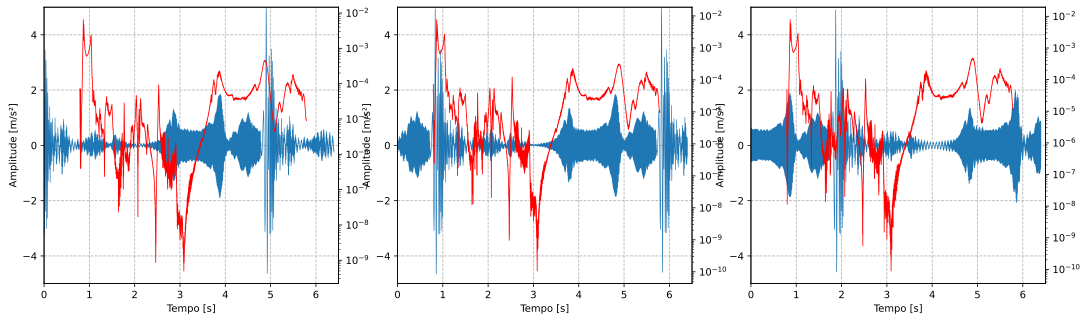

In [53]:
# 2GDL
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


two_dgof_time = (
    experiment_data.filter((pl.col("type") == "2GDL") & (pl.col("domain") == "time"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

two_dgof_freq = (
    experiment_data.filter((pl.col("type") == "2GDL") & (pl.col("domain") == "frequency"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    ax2 = ax.twinx()
    current_run_time = two_dgof_time.filter(pl.col("run") == (idx + 1))
    current_run_freq = two_dgof_freq.filter(pl.col("run") == (idx + 1))
    ax.plot(current_run_time.select("x"), current_run_time.select("amplitude"), linewidth=0.6)
    ax2.semilogy((current_run_freq.select("x") / 200) + 0.79, current_run_freq.select("amplitude"), linewidth=.8, color="r")
    ax.set_xlim((0, 6.5))
    ax.set_ylim((-5, 5))
    ax.set_xlabel("Tempo [s]")
    ax.set_ylabel("Amplitude [m/s²]")
    ax.grid(axis="both", linestyle="--")

plt.savefig("experimento4/time_2gdl.eps", format="eps", bbox_inches="tight")
plt.show()

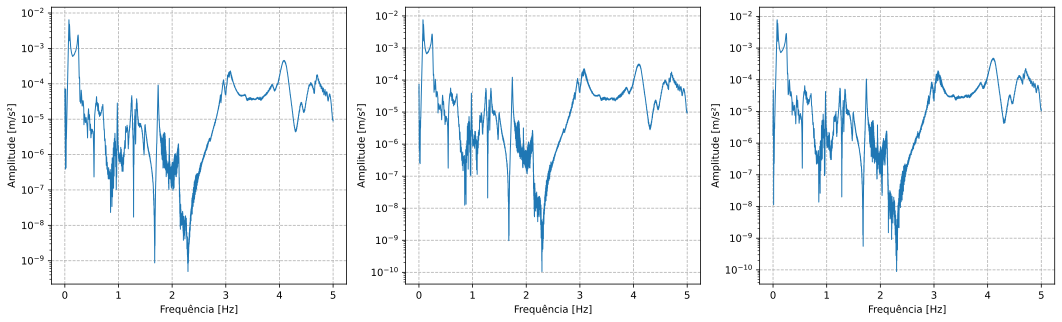

In [30]:
# 2GDL
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


two_dgof_freq = (
    experiment_data.filter((pl.col("type") == "2GDL") & (pl.col("domain") == "frequency"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = two_dgof_freq.filter(pl.col("run") == (idx + 1))
    ax.semilogy(current_run.select("x") / 200, current_run.select("amplitude"), linewidth=1)
    # ax.set_xlim((0, 6.5))
    # ax.set_ylim((-5, 5))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [m/s²]")
    ax.grid(axis="both", linestyle="--")

# plt.savefig("experimento4/time_2gdl.eps", format="eps", bbox_inches="tight")
plt.show()

In [ ]:
fig = px.scatter(two_dgof, x="x", y="amplitude")
fig.show()